<a href="https://colab.research.google.com/github/ChahineBA/Portfolio-Optimization/blob/main/Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  20 of 20 completed


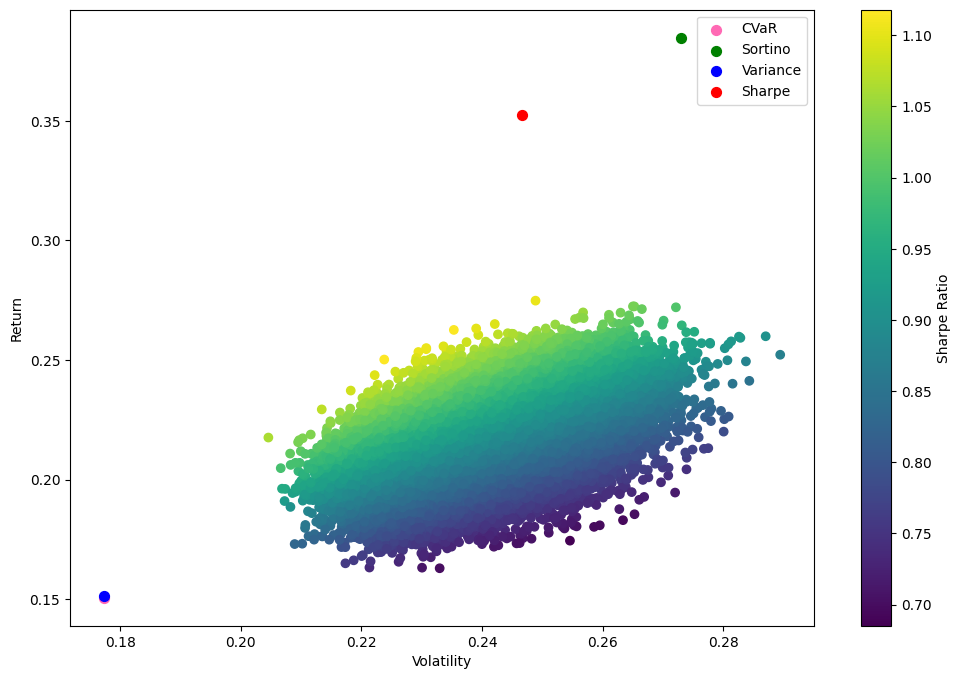





Optimal portfolio weights for CVaR:


GOOGL: practically 0%, ESG Score: 24
AMZN: 9.91%, ESG Score: 31
AAPL: 4.11%, ESG Score: 17
MSFT: practically 0%, ESG Score: 14
NFLX: 16.68%, ESG Score: 16
META: practically 0%, ESG Score: 34
JPM: practically 0%, ESG Score: 29
TSLA: 30.93%, ESG Score: 25
LLY: practically 0%, ESG Score: 24
NVDA: practically 0%, ESG Score: 14
AVGO: practically 0%, ESG Score: 20
V: 0.02%, ESG Score: 17
UNH: practically 0%, ESG Score: 15
MA: 0.37%, ESG Score: 17
XOM: practically 0%, ESG Score: 42
JNJ: 28.32%, ESG Score: 24
PG: practically 0%, ESG Score: 29
HD: practically 0%, ESG Score: 13
COST: practically 0%, ESG Score: 23
ABBV: 9.66%, ESG Score: 30


Descriptive statistics of the optimal portfolio for CVaR:


Annualized Return: 14.43
Annualized Volatility: 17.73
Skewness: -12.28
Kurtosis: 1002.00
Max Drawdown: -24.67
Data Count: 1258.00
Sharpe Ratio: 70.12
CVaR: 43.60
Sortino Ratio: 99.38
Variance: 3.14




Optimal portfolio weights for Sortino:


GOOGL: practica

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import gmean

# Select Optimization Criterion
optimization_criterion = 'variance'  # Change to 'sharpe', 'cvar', 'sortino', or 'variance' to optimize based on those criteria

# Choose Stocks to Add to the Portfolio and Select Sample Period
symbols = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'NFLX', 'META', 'JPM', 'TSLA',
                   'LLY', 'NVDA', 'AVGO', 'V', 'UNH', 'MA', 'XOM', 'JNJ', 'PG',
                   'HD', 'COST', 'ABBV']
start_date = '2018-01-01'
end_date = '2023-01-01'

# Download data from Yahoo Finance
df = yf.download(symbols, start=start_date, end=end_date)
data = df['Adj Close']
# Calculate returns:
returns = data.pct_change().dropna()
#ESG Scores:
esg_scores = {
    'GOOGL': 24, 'AAPL': 17, 'MSFT': 14, 'NVDA': 14, 'AMZN': 31,
    'META': 34, 'LLY': 24, 'NFLX': 16, 'AVGO': 20, 'JPM': 29,
    'TSLA': 25, 'V': 17, 'UNH': 15, 'XOM': 42, 'MA': 17, 'JNJ': 24,
    'PG': 29, 'HD': 13, 'COST': 23, 'ABBV': 30
}
esg_threshold = 15
# Define the objective function for Sharpe ratio optimization
def objective_sharpe(weights):
    # Calculate ESG penalty
    esg_penalty = np.sum(np.maximum(0, esg_threshold - np.array([esg_scores[symbol] for symbol in esg_scores.keys()])))
    sharpe_ratio = -np.dot(weights, returns.mean()) / np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return  sharpe_ratio

# Define the objective function for CVaR optimization
def objective_cvar(weights):
  # Calculate ESG penalty
    esg_penalty = np.sum(np.maximum(0, esg_threshold - np.array([esg_scores[symbol] for symbol in esg_scores.keys()])))
    portfolio_returns = np.dot(returns, weights)
    portfolio_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()
    conf_level = 0.05  # Confidence level for CVaR
    cvar = portfolio_mean - portfolio_std * norm.ppf(conf_level)
    return cvar

# Define the objective function for Sortino ratio optimization
def objective_sortino(weights):
    portfolio_returns = np.dot(returns, weights)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    sortino_ratio = portfolio_returns.mean() / downside_std
    return -sortino_ratio  # Maximize Sortino ratio

# Define the objective function for variance minimization
def objective_variance(weights):
    return np.dot(weights.T, np.dot(returns.cov() * 252, weights))

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Limits for the weights
bounds = tuple((0, 1) for x in range(len(symbols)))

# Optimization
init_guess = np.array(len(symbols) * [1. / len(symbols),])
if optimization_criterion == 'sharpe':
    opt_results = minimize(objective_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'cvar':
    opt_results = minimize(objective_cvar, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'sortino':
    opt_results = minimize(objective_sortino, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
elif optimization_criterion == 'variance':
    opt_results = minimize(objective_variance, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Optimal weights
optimal_weights = opt_results.x

# Optimize all criteria
opt_results_cvar = minimize(objective_cvar, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sortino = minimize(objective_sortino, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_variance = minimize(objective_variance, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sharpe = minimize(objective_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

# Optimal weights for each criterion
optimal_weights_cvar = opt_results_cvar.x
optimal_weights_sortino = opt_results_sortino.x
optimal_weights_variance = opt_results_variance.x
optimal_weights_sharpe = opt_results_sharpe.x

# Plot the efficient frontier
port_returns = []
port_volatility = []
sharpe_ratio = []
all_weights = []  # stores the weights of all simulated portfolios

num_assets = len(symbols)
num_portfolios = 50000

np.random.seed(101)


# Calculating portfolio returns and volatility for each portfolio
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns_portfolio = np.dot(weights, returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sr = returns_portfolio / volatility
    sharpe_ratio.append(sr)
    port_returns.append(returns_portfolio)
    port_volatility.append(volatility)
    all_weights.append(weights)  # records weights for this portfolio

# Plotting the efficient frontier
plt.figure(figsize=(12, 8))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

# Calculating and plotting the returns and volatility of the optimal portfolio for each criterion
opt_returns_cvar = np.dot(optimal_weights_cvar, returns.mean()) * 252
opt_volatility_cvar = np.sqrt(np.dot(optimal_weights_cvar.T, np.dot(returns.cov() * 252, optimal_weights_cvar)))
opt_portfolio_cvar = plt.scatter(opt_volatility_cvar, opt_returns_cvar, color='hotpink', s=50, label='CVaR')

opt_returns_sortino = np.dot(optimal_weights_sortino, returns.mean()) * 252
opt_volatility_sortino = np.sqrt(np.dot(optimal_weights_sortino.T, np.dot(returns.cov() * 252, optimal_weights_sortino)))
opt_portfolio_sortino = plt.scatter(opt_volatility_sortino, opt_returns_sortino, color='g', s=50, label='Sortino')

opt_returns_variance = np.dot(optimal_weights_variance, returns.mean()) * 252
opt_volatility_variance = np.sqrt(np.dot(optimal_weights_variance.T, np.dot(returns.cov() * 252, optimal_weights_variance)))
opt_portfolio_variance = plt.scatter(opt_volatility_variance, opt_returns_variance, color='b', s=50, label='Variance')

opt_returns_sharpe = np.dot(optimal_weights_sharpe, returns.mean()) * 252
opt_volatility_sharpe = np.sqrt(np.dot(optimal_weights_sharpe.T, np.dot(returns.cov() * 252, optimal_weights_sharpe)))
opt_portfolio_sharpe = plt.scatter(opt_volatility_sharpe, opt_returns_sharpe, color='r', s=50, label='Sharpe')

plt.legend(loc='upper right')

plt.show()


# Function to calculate maximum drawdown
def max_drawdown(return_series):
    comp_ret = (1 + return_series).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak) - 1
    return dd.min()

# Function to calculate more detailed descriptive statistics
def detailed_portfolio_statistics(weights):
    portfolio_returns = returns.dot(weights)

    # General descriptive statistics
    mean_return_annualized = gmean(portfolio_returns + 1)**252 - 1
    std_dev_annualized = portfolio_returns.std() * np.sqrt(252)
    skewness = skew(portfolio_returns)
    kurt = kurtosis(portfolio_returns)
    max_dd = max_drawdown(portfolio_returns)
    count = len(portfolio_returns)

    # Optimization metrics
    risk_free_rate = 0.02
    sharpe_ratio = (mean_return_annualized - risk_free_rate) / std_dev_annualized
    conf_level = 0.05
    cvar = mean_return_annualized - std_dev_annualized * norm.ppf(conf_level)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std_dev = downside_returns.std() * np.sqrt(252)
    sortino_ratio = mean_return_annualized / downside_std_dev
    variance = std_dev_annualized ** 2

    return mean_return_annualized, std_dev_annualized, skewness, kurt, max_dd, count, sharpe_ratio, cvar, sortino_ratio, variance

# Calculating statistics for each portfolio
statistics_cvar = detailed_portfolio_statistics(optimal_weights_cvar)
statistics_sortino = detailed_portfolio_statistics(optimal_weights_sortino)
statistics_variance = detailed_portfolio_statistics(optimal_weights_variance)
statistics_sharpe = detailed_portfolio_statistics(optimal_weights_sharpe)


# Names of the statistics
statistics_names = ['Annualized Return', 'Annualized Volatility', 'Skewness', 'Kurtosis', 'Max Drawdown', 'Data Count', 'Sharpe Ratio', 'CVaR', 'Sortino Ratio', 'Variance']

# Dictionary associating optimization method names with optimal weights and statistics
portfolio_data = {
    'CVaR': {
        'weights': optimal_weights_cvar,
        'statistics': detailed_portfolio_statistics(optimal_weights_cvar)
    },
    'Sortino': {
        'weights': optimal_weights_sortino,
        'statistics': detailed_portfolio_statistics(optimal_weights_sortino)
    },
    'Variance': {
        'weights': optimal_weights_variance,
        'statistics': detailed_portfolio_statistics(optimal_weights_variance)
    },
    'Sharpe': {
        'weights': optimal_weights_sharpe,
        'statistics': detailed_portfolio_statistics(optimal_weights_sharpe)
    },
}

# Print the weights and statistics for each optimization method
for method, data in portfolio_data.items():
    print("\n")
    print("========================================================================================================")
    print("\n")
    print(f"Optimal portfolio weights for {method}:")
    print("\n")
    for symbol, weight in zip(symbols, data['weights']):
        if weight < 1e-4:  # consider any weight less than 0.01% as zero
            esg_score = esg_scores.get(symbol, "N/A")
            print(f"{symbol}: practically 0%, ESG Score: {esg_score}")
        else:
            esg_score = esg_scores.get(symbol, "N/A")  # Retrieve ESG score or default to "N/A" if not available
            print(f"{symbol}: {weight*100:.2f}%, ESG Score: {esg_score}")

    print("\n")
    print(f"Descriptive statistics of the optimal portfolio for {method}:")
    print("\n")
    for name, stat in zip(statistics_names, data['statistics']):
        print(f"{name}: {stat*100 if name != 'Data Count' else stat:.2f}")

print("\n")
print("========================================================================================================")

# models

In [ ]:
!pip install pandas numpy matplotlib PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.5.5'

In [ ]:
def get_closing_prices(symbols, start_date, end_date):
    closing_prices = {}
    for symbol in symbols:
        try:
            data = yf.download(symbol, start=start_date, end=end_date)
            closing_prices[symbol] = data['Adj Close']
        except Exception as e:
            print(f"Failed to fetch data for {symbol}: {e}")
    return pd.DataFrame(closing_prices)

## Black-Litterman allocation

In [ ]:
prices = get_closing_prices(symbols, start_date, end_date)
prices.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,GOOGL,AMZN,AAPL,MSFT,NFLX,META,JPM,TSLA,LLY,NVDA,AVGO,V,UNH,MA,XOM,JNJ,PG,HD,COST,ABBV
Date,,,,,,,,,,,,,,,,,,,,
2022-12-23,89.230003,85.250000,130.959946,236.195023,294.959991,117.914894,126.698769,123.150002,363.669159,151.985428,537.846191,203.828278,521.374390,340.978851,104.124245,170.954956,147.907379,308.257233,448.304230,155.283310
2022-12-27,87.389999,83.040001,129.142441,234.443817,284.170013,116.756119,127.142715,109.099998,360.683929,141.140762,538.926819,204.283813,522.041687,343.519318,105.570961,170.906784,149.196274,309.050262,444.282928,155.178574
2022-12-28,86.019997,81.820000,125.179680,232.039627,276.880005,115.497459,127.837578,112.709999,361.020020,140.291168,530.505249,202.996460,518.567871,339.341431,103.836823,170.165131,147.267746,305.355804,438.943787,154.455002
2022-12-29,88.449997,84.180000,128.725311,238.450821,291.119995,120.132538,128.571060,121.820000,362.799347,145.958389,543.084167,206.036591,519.971069,345.553650,104.622444,171.032028,147.878281,309.881989,442.374023,154.769150
2022-12-30,88.230003,84.000000,129.043121,237.273438,294.880005,120.212448,129.420349,123.180000,361.632874,146.068329,544.369263,205.739517,520.265442,345.077332,105.676338,170.155457,146.880066,305.481476,442.344940,153.864700


In [ ]:
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'GOOGL': 1882413989888,
 'AMZN': 1873679220736,
 'AAPL': 2647976837120,
 'MSFT': 3126134571008,
 'NFLX': 262828130304,
 'META': 1237942534144,
 'JPM': 576938115072,
 'TSLA': 559854190592,
 'LLY': 739657973760,
 'NVDA': 2258900090880,
 'AVGO': 614222856192,
 'V': 573249814528,
 'UNH': 456080752640,
 'MA': 449252818944,
 'XOM': 461221724160,
 'JNJ': 381203087360,
 'PG': 381777477632,
 'HD': 380153757696,
 'COST': 324924342272,
 'ABBV': 322435383296}

In [ ]:
market_prices = yf.download("SPY", start_date, end_date)["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    242.319321
2018-01-03    243.852036
2018-01-04    244.879898
2018-01-05    246.511719
2018-01-08    246.962585
Name: Adj Close, dtype: float64

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

1.961808350793489

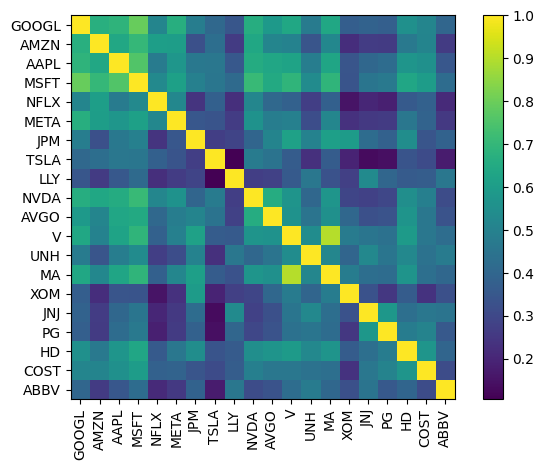

In [ ]:
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

GOOGL    0.165318
AMZN     0.173318
AAPL     0.175054
MSFT     0.172773
NFLX     0.176809
META     0.189406
JPM      0.119943
TSLA     0.215661
LLY      0.091456
NVDA     0.256086
AVGO     0.169647
V        0.139936
UNH      0.113254
MA       0.155170
XOM      0.099002
JNJ      0.073857
PG       0.076062
HD       0.127763
COST     0.103901
ABBV     0.090694
dtype: float64

This line calculates the market-implied prior returns using the Black-Litterman
framework.
`black_litterman.market_implied_prior_returns()` is a function call that calculates the market-implied prior returns based on the following parameters:
*   **mcaps**: A vector or array-like object containing the market capitalizations of assets.
*   **delta**: The market implied risk aversion parameter.
* **S**: The covariance matrix of asset returns, typically estimated using historical data or other methods.
* The market_prior variable will contain the calculated market-implied prior
returns, which represent the expected returns of assets implied by the market prices and risk aversion parameter.
These returns serve as a starting point for the Black-Litterman model, which combines them with investor views to generate updated expected returns for portfolio optimization

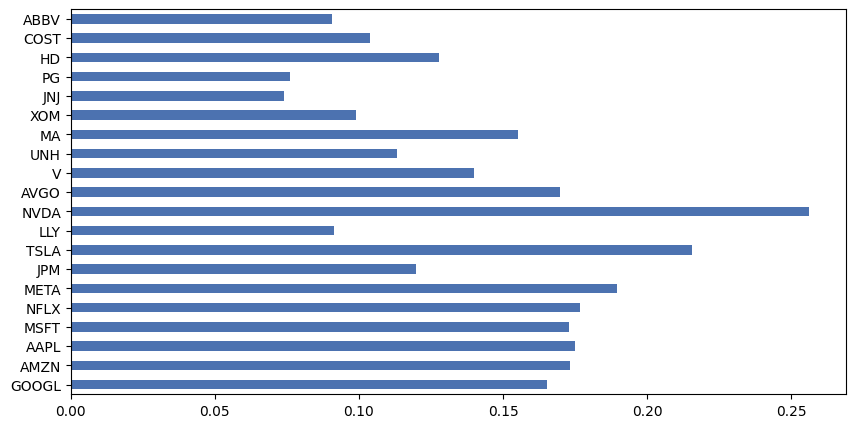

In [ ]:
market_prior.plot.barh(figsize=(10,5));

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing absolute views (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [ ]:
# You don't have to provide views on all the assets
viewdict = {
    "GOOGL": 0.15,
    "AMZN": 0.20,
    "AAPL": 0.10,
    "MSFT": 0.15,
    "NFLX": 0.10,
    "META": 0.25,
    "JPM": 0.20,
    "TSLA": 0.25,
    "LLY": 0.15,  # but low confidence, which will be reflected later
    "NVDA": 0.20
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [ ]:
confidences = [
    0.6,
    0.8,
    0.7,
    0.8,
    0.6,
    0.7,
    0.7,
    0.7,
    0.7,
    0.8
]

In [ ]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

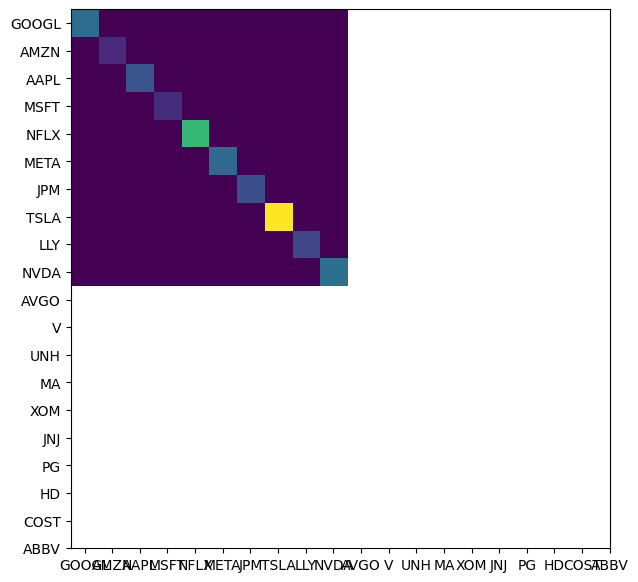

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
np.diag(bl.omega)

array([0.00329845, 0.00113034, 0.00240631, 0.00120901, 0.00608991,
       0.00309838, 0.00221222, 0.00910334, 0.00193566, 0.00333759])

Note how NFLX, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]



> **Posterior estimates**


Given the inputs, we can compute a posterior estimate of returns

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

GOOGL    0.166998
AMZN     0.162842
AAPL     0.168905
MSFT     0.168057
NFLX     0.121109
META     0.224819
JPM      0.164851
TSLA     0.248772
LLY      0.081794
NVDA     0.249103
AVGO     0.176726
V        0.149671
UNH      0.114494
MA       0.169631
XOM      0.118991
JNJ      0.066539
PG       0.067732
HD       0.132614
COST     0.090252
ABBV     0.086882
dtype: float64

We can visualise how this compares to the prior and our views:

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
GOOGL,0.165318,0.166998,0.15
AMZN,0.173318,0.162842,0.20
AAPL,0.175054,0.168905,0.10
MSFT,0.172773,0.168057,0.15
NFLX,0.176809,0.121109,0.10
META,0.189406,0.224819,0.25
JPM,0.119943,0.164851,0.20
TSLA,0.215661,0.248772,0.25
LLY,0.091456,0.081794,0.15
NVDA,0.256086,0.249103,0.20


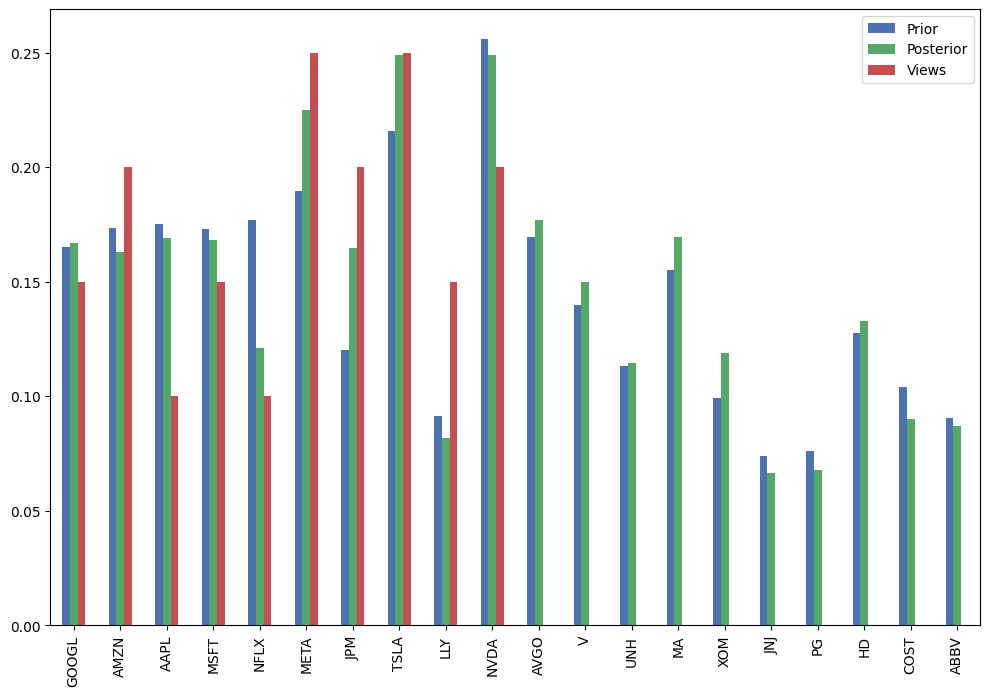

In [ ]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

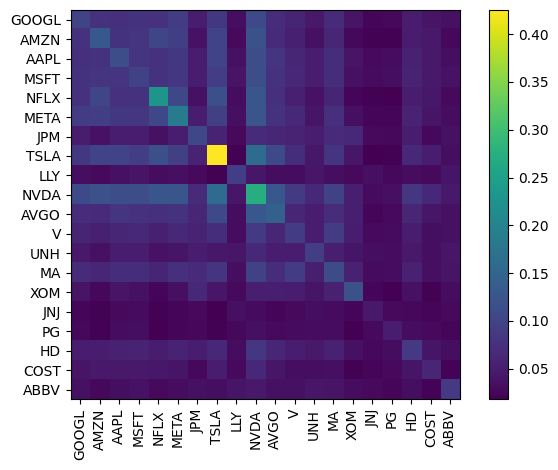

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.



In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('GOOGL', 0.06106),
             ('AMZN', 0.05534),
             ('AAPL', 0.05873),
             ('MSFT', 0.05929),
             ('NFLX', 0.014),
             ('META', 0.09834),
             ('JPM', 0.07392),
             ('TSLA', 0.09048),
             ('LLY', 0.02129),
             ('NVDA', 0.08938),
             ('AVGO', 0.06225),
             ('V', 0.05303),
             ('UNH', 0.03642),
             ('MA', 0.06286),
             ('XOM', 0.04338),
             ('JNJ', 0.01482),
             ('PG', 0.01502),
             ('HD', 0.04491),
             ('COST', 0.022),
             ('ABBV', 0.02348)])

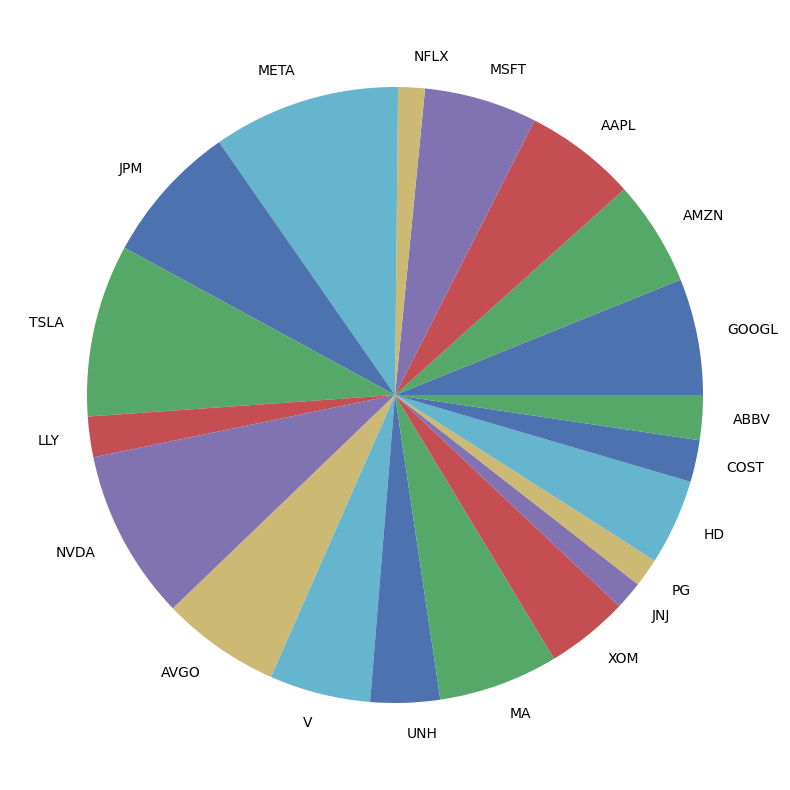

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [ ]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=10000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $2.91


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'GOOGL': 7,
 'AMZN': 7,
 'AAPL': 4,
 'MSFT': 3,
 'META': 8,
 'JPM': 6,
 'TSLA': 7,
 'LLY': 1,
 'NVDA': 6,
 'AVGO': 1,
 'V': 3,
 'UNH': 1,
 'MA': 2,
 'XOM': 4,
 'JNJ': 1,
 'PG': 1,
 'HD': 1,
 'ABBV': 2}

In [ ]:
# Calculate the total allocation
total_allocation = sum(alloc.values())

# Convert the allocation to percentages
allocation_percentages = {asset: (units / total_allocation) * 100 for asset, units in alloc.items()}

# Print the percentage allocation
print("Percentage Allocation:")
for asset, percentage in allocation_percentages.items():
    print(f"{asset}: {percentage:.2f}%")

Percentage Allocation:
GOOGL: 10.77%
AMZN: 10.77%
AAPL: 6.15%
MSFT: 4.62%
META: 12.31%
JPM: 9.23%
TSLA: 10.77%
LLY: 1.54%
NVDA: 9.23%
AVGO: 1.54%
V: 4.62%
UNH: 1.54%
MA: 3.08%
XOM: 6.15%
JNJ: 1.54%
PG: 1.54%
HD: 1.54%
ABBV: 3.08%
